# Transfer Learning

transfer learning is taking all or part of a model that is already trained on an specific task and using its learning on a whole new task, the base model is called the pre-trained model and the new model is called the fine-tuned model. being fine-tuning the process of adjust the base model architecture and weights to the new task in hand.

The example we will develop consist of a model capable detecting and labeling objects in images, we will fine tune this model to classify flower species.

## How does this work

there are 2 main ways to implement transfer learning:
1. we can get rid of the output layer of the pre-trained model and add a new one with the number of classes we want to predict, then we freeze the weights of the pre-trained model and train the new output layer.

2. we can replace some of the final layers including the output layer with new ones.

how many layers we replace or add will depend on how similar the two tasks in hand are.After removing or adding the layers we need to fine-tune or train the model with our own data.

Lets take into consideration that *the deeper you go in your deep neural network the higher level features you are going to be able to recognize* this means that if we have a cnn that can identify human faces, in the first layers it will be able to recognize edges and shapes, in the middle layers it will be able to recognize eyes, noses, mouths, etc. and in the final layers it will be able to recognize faces. If we want to fine-tune this model to detect god faces, we will need to remove the final layers and add new ones that can recognize dog faces. but we will keep the majority of the layers because they are already able to recognize the features we need like shapes and edges.

## Why Transfer Learning

- Lack of Data

The main problem this technique solves is the need of a large amount of data to train a deep neural network, this is because the first layers of a deep neural network are able to recognize low level features like edges and shapes, and this features are common in many tasks, so we can use a pre-trained model that already knows how to recognize this features and fine-tune it to our task.

- Save time
  
once a generalized model is build it can be used in many different tasks, so we can save a lot of time by using a pre-trained model and fine-tune it to our task

- Reduce Carbon Footprint

by sharing pre-trained model we save compute power and reduce the carbon footprint of our models.

## Fine-tuning Xception
the first step is to get your hands on a pre-trained generealized model, in this case we will use Xception.

*Xception* is a deep convolutional neural network that is 71 layers deep, it was trained on the imagenet dataset, which contains 350 million images and 70000 classes. *Xception* is a great model for image labeling, so we will use it as our base model. it is provided by the Keras application library.

the dataset we will use to fine-tune the model is called tf-flowers, it contains 3670 images of 5 different flower species.

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

/Users/atorres/.local/share/virtualenvs/transfer-learning-RVGJrPHs-python/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset, info = tfds.load("tf_flowers",
                          as_supervised=True,
                          with_info=True)

Dl Completed...: 100%|██████████| 5/5 [00:07<00:00,  1.50s/ file]

Dataset tf_flowers downloaded and prepared to /Users/atorres/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


the **with_info** argument is used to retrieve the metadata associated with the dataset. This metadata object contains the number of classes, the names of the classes, and other useful information.

In [5]:
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

print(dataset_size)
print(class_names)
print(n_classes)

3670
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
5


this dataset only provides us one split or set of photos so that is why we need to split the data by ourselves

In [6]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("tf_flowers",
                        split=["train[:10%]",
                               "train[10%:25%]",
                               "train[25%:]"],
                        as_supervised=True)

## Pre process the ingest data


we need to make sure our data is structured in a way the model can process correctly.to achieve this we will rezise the image to match the input layer architecture and the number of channels in the CNN
the *preprocess_input* function preprocesses a tensor or Numpy array encoding a batch of images for *Xception*

In [7]:
def preprocess(image,label):
    resized_image = tf.image.resize(image, [224,224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


## prepare the data for the model

we will first shuffle the data with a memory buffer of 1000 entries and then apply the pre-process function to each element in the dataset. After that we will batch the data into batches of 32 elements. Finally we will prefetch the data to the GPU to speed up training, this mean the means that we can pre fetch the next batch of data while the model is been trained on the current batch.

In [8]:
batch_size = 32

train_set = train_set_raw.shuffle(1000).map(preprocess).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)

test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

## The actual Transfer Learning process

base_model contains a an ini memory reference to the actual model with all of its layers and weights, but we will opt out the top layers this contains the AveragePooling layer and the output layers which classifies the images.

Instead we will create our own AveragePooling layer and output layer using the functional API of keras.

Finally we combine all of them together in the new_model.

In [17]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                            include_top=False)


avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)


new_model = tf.keras.Model(inputs=base_model.input, outputs=output)

 now we need to freeze the weights for all the other layers in the model, this means it will not adjust the weights for those layers during training and will no back propagate the errors to those layers. We can do this by iterating through all the layers in the model and setting the trainable attribute to False for each layer.

In [18]:
for layer in base_model.layers:
  layer.trainable = False

we define an optimizer, in this case classic Stochastic gradient decent with momentum technique, weight decay and a learning rate of 0.2, this is a quite high learning rate, this is a fairly common practice in fine tunning as we are not training the whole network, we are just adjusting the last layers and we need these layers to catch up with the rest of the model.

then we compile the model using categorical crossentropy as our loss function and accuracy as our metric.

finally we train the model for 5 epochs.

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2,
                                    momentum=0.9,
                                    weight_decay=0.01)

new_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


history = new_model.fit(train_set,
                    epochs=5,
                    validation_data=valid_set)

Epoch 1/5
86/86 [==============================] - 88s 1s/step - loss: 1.5409 - accuracy: 0.7900 - val_loss: 1.1238 - val_accuracy: 0.8385
Epoch 2/5
86/86 [==============================] - 86s 1s/step - loss: 0.8614 - accuracy: 0.8812 - val_loss: 1.0862 - val_accuracy: 0.8548
Epoch 3/5
86/86 [==============================] - 92s 1s/step - loss: 0.6382 - accuracy: 0.9023 - val_loss: 1.2699 - val_accuracy: 0.8621
Epoch 4/5
86/86 [==============================] - 87s 1s/step - loss: 0.3235 - accuracy: 0.9419 - val_loss: 1.1545 - val_accuracy: 0.8693
Epoch 5/5
86/86 [==============================] - 85s 988ms/step - loss: 0.1535 - accuracy: 0.9640 - val_loss: 1.1168 - val_accuracy: 0.8675


## Revision the Training results

After the training phase we can notice we did not make that much of an improvement in terms of validation accuracy but we got a loss reduction. This indicate our top layers perform well in terms of the whole model and it might be a sign that now need to train the whole model to get better results in a holistic fashion.

In [20]:
for layer in base_model.layers:
  layer.trainable = True

Once all the layers are set to trainable we can start training all the weights, now using 10 epochs.And a way lower learning rate. we do not want to mess with the parameters of the base model that much.

In [22]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,
                                    momentum=0.9,
                                    weight_decay=0.001)

new_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

history = new_model.fit(train_set,
                    epochs=10,
                    validation_data=valid_set)

Epoch 1/10
86/86 [==============================] - 382s 4s/step - loss: 0.4415 - accuracy: 0.8616 - val_loss: 0.6239 - val_accuracy: 0.8367
Epoch 2/10
86/86 [==============================] - 360s 4s/step - loss: 0.1060 - accuracy: 0.9695 - val_loss: 0.3740 - val_accuracy: 0.8857
Epoch 3/10
86/86 [==============================] - 359s 4s/step - loss: 0.0604 - accuracy: 0.9804 - val_loss: 0.3939 - val_accuracy: 0.8966
Epoch 4/10
86/86 [==============================] - 362s 4s/step - loss: 0.0324 - accuracy: 0.9898 - val_loss: 0.2915 - val_accuracy: 0.9183
Epoch 5/10
86/86 [==============================] - 368s 4s/step - loss: 0.0159 - accuracy: 0.9938 - val_loss: 0.4081 - val_accuracy: 0.9165
Epoch 6/10
86/86 [==============================] - 361s 4s/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 0.3585 - val_accuracy: 0.9147
Epoch 7/10
86/86 [==============================] - 362s 4s/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 0.3379 - val_accuracy: 0.9147
Epoch 8/10
86

we got a significant increase in the validation accuracy with a holistic approach.

now we can save it in a .h5 format and export it

In [23]:
new_model.save('Xception-ft-tf_flowers-29-07-23.h5')

/Users/atorres/.local/share/virtualenvs/transfer-learning-RVGJrPHs-python/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
loaded_model = tf.keras.models.load_model('./Xception-ft-tf_flowers-29-07-23.h5')

we will get 3 entries from the dataset we used

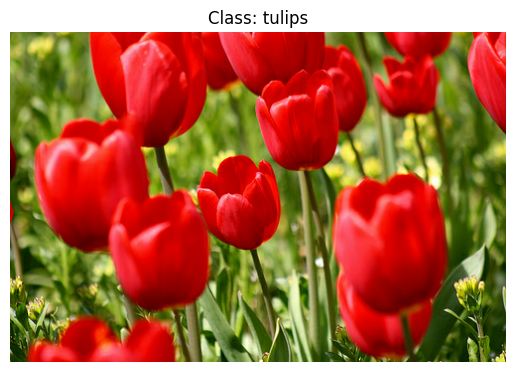

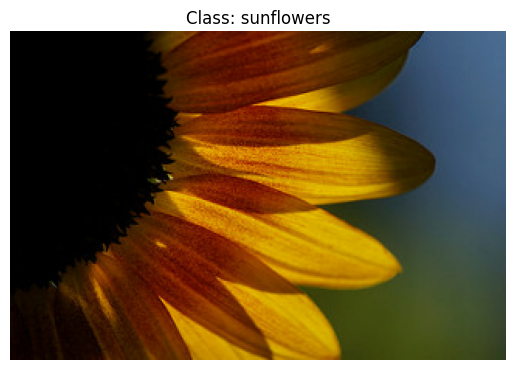

2023-07-29 17:55:07.911740: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


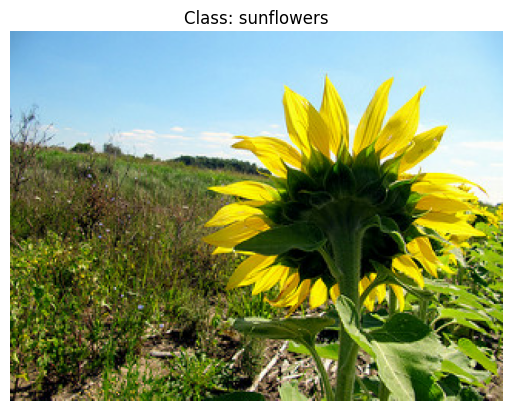

In [47]:
import matplotlib.pyplot as plt

entries = dataset['train'].take(3)

for image, label in entries:
    image = image.numpy()
    class_name = info.features['label'].int2str(label.numpy())

    plt.imshow(image)
    plt.title(f"Class: {class_name}")
    plt.axis('off')
    plt.show()

lets predict the class of this entry using the loaded model

we will need a preprocess function to resize the image to the size the model expects, also we will need to add an  additional batch dimension to the tensor because the model expects batches of images as input, you can think of it as each picture being a figure but the model expects a cube of images 

1/1 [==============================] - 0s 52ms/step


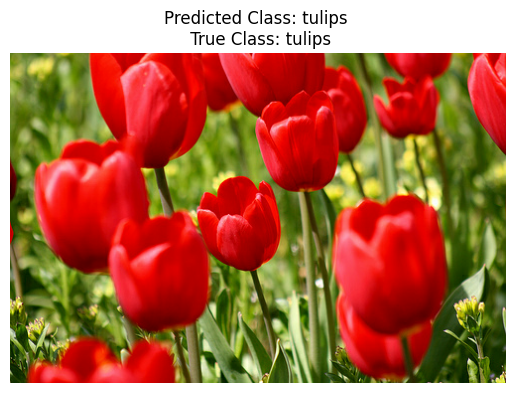

1/1 [==============================] - 0s 69ms/step


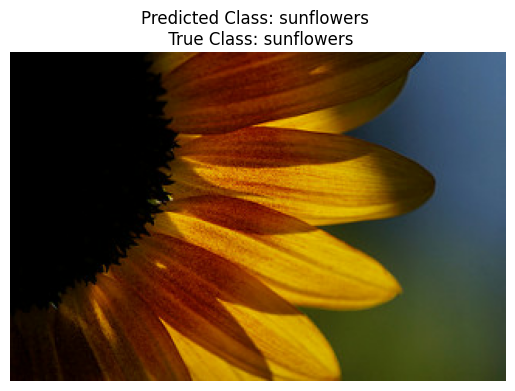

1/1 [==============================] - 0s 85ms/step


2023-07-29 18:06:53.639624: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


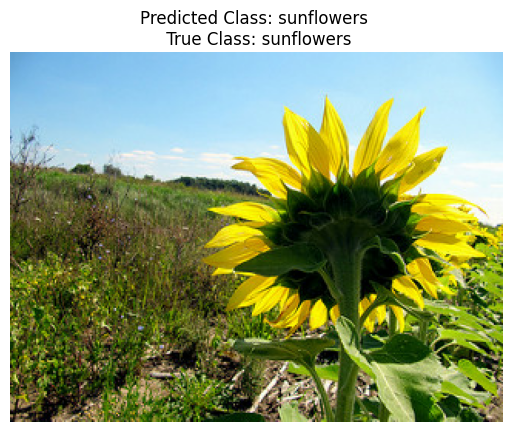

In [60]:
def preprocess_image(image):
    resized_image = tf.image.resize(image, [224,224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    # Add a batch dimension as the Xception model expects batches of images
    return tf.expand_dims(final_image, axis=0)


# Extract the image and label from the entry
for image, label in entries:
    preprocessed_image = preprocess_image(image)
    
    prediction = loaded_model.predict(preprocessed_image)
    
    # Get the class index with the highest probability
    predicted_class_index = tf.argmax(prediction, axis=1).numpy()[0]
    
    predicted_class_name = info.features['label'].int2str(predicted_class_index)
    true_class_name = info.features['label'].int2str(label.numpy())
    plt.imshow(image.numpy())
    plt.title(f"Predicted Class: {predicted_class_name} \n True Class: {true_class_name}")
    plt.axis('off')
    plt.show()